In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   #all libaries are imported 
import spacy  # For preprocessing
nlp = spacy.load('en_core_web_lg') #loading the spacy for english lamguage
import re  # For preprocessing
from collections import defaultdict  # For word frequency

In [30]:
import glob                  #to read all text documents and copy all the sentences into a single text file

read_files = glob.glob("*.txt")

with open("result.txt", "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

In [73]:
df = pd.read_csv('result.csv') #loading the data

In [74]:
df.head()

,text,label
0,"One Lakshminarayana Iyer, a Hindu Brahmin, who...",Facts
1,Ramalakshmi had married the plaintiff and had ...,Facts
2,"They were all alive in December, 1924, when La...",Facts
3,Before his death he executed a will on 16th No...,Ratio of the decision
4,By this will he gave the following directions ...,Facts


In [57]:
df.isnull().sum()   #to check if any value is NaN

text     0
label    0
dtype: int64

In [58]:
df['label'].unique()    #all 7-labels present

array(['Facts', 'Ratio of the decision', 'Ruling by Lower Court',
       'Argument', 'Ruling by Present Court', 'Precedent', 'Statute'],
      dtype=object)

In [5]:
df['label'].value_counts()  #no. of sentences in each class

Ratio of the decision      3326
Facts                      1985
Precedent                  1330
Argument                    736
Statute                     541
Ruling by Lower Court       269
Ruling by Present Court     219
Name: label, dtype: int64

<BarContainer object of 7 artists>

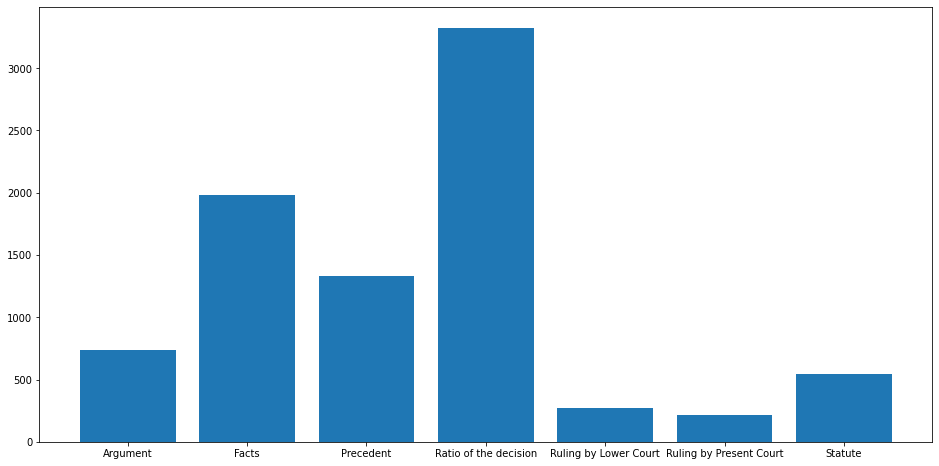

In [15]:
categories, ccount = np.unique(df['label'], return_counts=True)    #distribution of data
plt.figure(figsize=(16, 8))
plt.bar(categories, ccount, align='center')                   

In [81]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [82]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])

In [83]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]  #preprocessing using spacy library

In [94]:
df_clean = pd.DataFrame({'clean': txt})
df_clean.shape

(8406, 1)

In [95]:
u=df['label']
u.shape

(8406,)

In [96]:
df_clean= df_clean.join(u)

In [98]:
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(7722, 2)

In [105]:
from sklearn.model_selection import train_test_split   #split in training and testing
X=df_clean['clean']                                                                  
y=df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

In [106]:
X_train.head()   #training data input

7428    permit appellant argue case acquittal merit ob...
148     hold construction nephew live amicably widow t...
1502    civil appeal stem revision petition high court...
4725    appellant ' case individual corporate appellan...
4490    litigant approach court bind produce document ...
Name: clean, dtype: object

In [107]:
y_train.head()

7428                 Argument
148                 Precedent
1502                    Facts
4725                    Facts
4490    Ratio of the decision
Name: label, dtype: object

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer  #TFIDF tokenization
vectorizer=TfidfVectorizer()
X_train_tfidf=vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(5173, 6084)

In [109]:
from sklearn.naive_bayes import MultinomialNB   #multinomial Classifier
clf=MultinomialNB()
clf.fit(X_train_tfidf,y_train)

MultinomialNB()

In [110]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('tfidf', TfidfVectorizer()),       #pipline defined
                     ('clf', MultinomialNB()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [111]:
predictions = text_clf.predict(X_test)  #prediction

In [ ]:
ls=[]

In [131]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))   #confusion matrix

[[  1  15  10 191   0   0   0]
 [  1 269   0 330   0   0   0]
 [  0   8  91 308   0   0   0]
 [  0  58  19 954   0   0   0]
 [  0  13   0  69   0   0   0]
 [  0   7   0  40   0   0   0]
 [  0   5   2 158   0   0   0]]


In [124]:
print(metrics.classification_report(y_test,predictions))           #classification report

                         precision    recall  f1-score   support

               Argument       0.50      0.00      0.01       217
                  Facts       0.72      0.45      0.55       600
              Precedent       0.75      0.22      0.34       407
  Ratio of the decision       0.47      0.93      0.62      1031
  Ruling by Lower Court       0.00      0.00      0.00        82
Ruling by Present Court       0.00      0.00      0.00        47
                Statute       0.00      0.00      0.00       165

               accuracy                           0.52      2549
              macro avg       0.35      0.23      0.22      2549
           weighted avg       0.52      0.52      0.44      2549



In [114]:
print(metrics.accuracy_score(y_test,predictions))

0.5158885837583366
